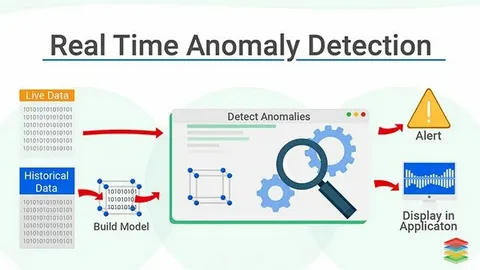

To begin with, anomaly detection is the process of identifying unusual patterns or outliers that deviate from expected behavior. These anomalies can indicate important events such as fraud, equipment failure, or security breaches.

Instead of using traditional supervised learning, anomaly detection often relies on unsupervised or semi-supervised methods since anomalies are rare and unpredictable.

* **Isolation Forest** – isolates anomalies by randomly partitioning data.
* **One-Class SVM** – defines a boundary around normal data points.
* **Autoencoders** – reconstruct normal data and flag high reconstruction errors as anomalies.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
import warnings
warnings.filterwarnings("ignore")

In [14]:
x, y = make_classification(n_samples = 2000, n_features = 20, n_informative = 10,
                           n_redundant = 5, n_clusters_per_class = 1, weights = [0.95],
                           flip_y = 0, random_state = 0)

# 0 = normal, 1 = anomaly

y[ : 100] = 1
y[100 : ] = 0

It generates a synthetic dataset with 2000 samples and 20 features, 10 features are informative (carry useful signal), 5 are redundant (linear combinations of informative), only one cluster per class; class imbalance is set with 95% in one class. Then tabels are manually set so the first 100 samples are labeled as anomalies (1), the rest as normal (0).


In [15]:
# Split data into train and test sets

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Scaling

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

* *Scaling*

Scaling in ML is all about getting your data to play nice together so your model doesn't trip over numbers that are on totally different scales like height in CMs say 180 and weight in KGs say 80 without scaling big numbers can bully smaller ones in algorithms like KNN, SVM or neural networks because they rely on distances or gradients scaling makes sure every feature gets an equal shot so your model learns better and faster its super important for stuff like gradient descent where big differences in scale can slow things down or mess up results plus it keeps things fair so no feature dominates just cause its numbers are bigger you dont always need scaling though like with decision trees or random forests since they don't care about scale but for most other models its a must.

Now, let's talk two big scaling methods **MinMaxScaler and Z-score** standardization a.k.a StandardScaler;

** *MinMaxScaler* ** takes your data and squashes it into a set range usually 0 to 1 it works by taking each value subtracting the smallest value in the feature and dividing by the range which is max minus min the formula is x scaled equals $X_{\text{scaled}} = \frac{X - X_{\min}}{X_{\max} - X_{\min}}$* so if the heights are 170, 180, 190 the "min is 170",  "max is 190",  "range is 20". Thus,

* 180 => 180 minus 170 divided by 20 which is *0.5*
* 170 => 170 minus 170 divided by 20 which is *0.0*
* 190 => 190 minus 170 divided by 20 which is *1.0*

Eventually, this puts everything between 0 and 1 keeping the relative distances between values its great for models that like bounded data like NNs but watch out for outliers cause a crazy high or low value can squish everything else.

On the other hand, * **Z-score standardization or StandardScaler** * is different it makes your data have a mean of 0 and a standard deviation of 1 basically centering it around zero with a consistent spread the formula is, ($X_{\text{scaled}} = \frac{X - \mu}{\sigma}$). This method assumes your data is kinda normal bell curve ish and works awesome for algorithms like linear regression or SVM but outliers can mess with the mean and standard deviation so if your data’s wild you might need something else like RobustScaler.

* Mean: $\mu = \frac{180 + 170 + 190}{3} = 180$
* Std: $\sigma = \sqrt{\frac{(180-180)^2 + (170-180)^2 + (190-180)^2}{3}} = \sqrt{\frac{0 + 100 + 100}{3}} \approx 8$

Then;
* Z(180) => 180 minus 180 divided by 8 which is *0.0*
* Z(170) => 170 minus 180 divided by 8 which is *-1.2*
* Z(190) => 190 minus 180 divided by 8 which is *1.2*

Key points always scale after splitting your data into training and test sets to avoid data leakage where test info sneaks into training only fit your scaler on training data then use it to transform both training and test data MinMax is good for bounded ranges Z-score is better for normally distributed data if you got outliers RobustScaler might be your friend since it uses medians instead of means you can also reverse scaling to get back to original values which is handy for interpreting results.


In [16]:
# Isolation Forest

iso_forest = IsolationForest(contamination = 0.05, random_state = 42)
iso_forest.fit(x_train)
pred_iso = iso_forest.predict(x_test)
pred_iso = np.where(pred_iso == -1, 1, 0)

### Isolation Forest

Firstly, it randomly select a feature and split value to isolate points, and isolates anomalies by randomly partitioning the data space. In addition, it predicts *-1* for anomalies and *1* for normal points.


Note: **anomaly score** for a point x is based on path length h(x) in trees:

*Formula:*  $s(x, n) = 2^{-\frac{h(x)}{c(n)}}$

in formula, $c(n)$ is the average path length of unsuccessful searches in a binary tree. Points with shorter average path lengths have higher anomaly scores.

In [17]:
# One-Class SVM

oc_svm = OneClassSVM(nu = 0.05, kernel = "rbf", gamma = 0.01)
oc_svm.fit(x_train)
pred_svm = oc_svm.predict(x_test)
pred_svm = np.where(pred_svm == -1, 1, 0)

### One-Class SVM


* It tries to separate all data from the origin in a high-dimensional feature space, and predicts -1 for outliers (anomalies), 1 for inliers (normal). Then predictions converted to `1` for anomaly and `0` for normal.

*Formula:* $\min_{w, \rho, \xi} \frac{1}{2} \|w\|^2 + \frac{1}{\nu n} \sum_i \xi_i - \rho$

subject to: $(w \cdot \phi(x_i)) \geq \rho - \xi_i, \quad \xi_i \geq 0$

In here,

* $\phi(\cdot)$ is the kernel function mapping to feature space (RBF kernel here).
* $\nu$ controls the fraction of outliers/anomalies.
* Decision function: classify as anomaly if

*Formula:* $f(x) = \text{sign} (w \cdot \phi(x) - \rho) < 0$

In [18]:
# Autoencoder

input_dim = x_train.shape[1]
input_layer = Input(shape = (input_dim,))
encoded = Dense(14, activation = 'relu', activity_regularizer = regularizers.l1(1e-5))(input_layer)
encoded = Dense(7, activation = 'relu')(encoded)
decoded = Dense(14, activation = 'relu')(encoded)
decoded = Dense(input_dim, activation = 'linear')(decoded)

autoencoder = Model(inputs = input_layer, outputs = decoded)
autoencoder.compile(optimizer = 'adam', loss = 'mse')

autoencoder.fit(x_train, x_train, epochs = 20, batch_size = 32,
                shuffle = True, validation_split = 0.1, verbose = 0)

reconstructions = autoencoder.predict(x_test)
mse = np.mean(np.power(x_test - reconstructions, 2), axis = 1)
threshold = np.percentile(mse, 95)
pred_ae = np.where(mse > threshold, 1, 0)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


### Autoencoder


* Autoencoder neural network compresses and then reconstructs input data.
* Trained on normal data to minimize reconstruction error.
* Anomalies are expected to have higher reconstruction error (MSE).
* A threshold is set at the 95th percentile of reconstruction errors.
* Samples with error above threshold are classified as anomalies 1, others normal 0.

Additionally,

* Neural network with encoder $f_\theta$ and decoder $g_\phi$:

*Formula:* $\hat{x} = g_\phi(f_\theta(x))$

* Objective: minimize reconstruction loss (Mean Squared Error):

*Formula:* $L = \frac{1}{n} \sum_{i=1}^n \|x_i - \hat{x}_i\|^2$

* Anomalies have high reconstruction error $\|x - \hat{x}\|^2$, thus detected by thresholding MSE.

In [19]:
# 6. Evaluation Function

def evaluate(y_true, pred, model_name):
    precision = precision_score(y_true, pred)
    recall = recall_score(y_true, pred)
    f1 = f1_score(y_true, pred)
    print(f"{model_name}\n Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Evaluation
evaluate(y_test, pred_iso, "Isolation Forest")
evaluate(y_test, pred_svm, "One-Class SVM")
evaluate(y_test, pred_ae, "Autoencoder")

Isolation Forest
 Precision: 0.0385, Recall: 0.0417, F1 Score: 0.0400
One-Class SVM
 Precision: 0.0385, Recall: 0.0417, F1 Score: 0.0400
Autoencoder
 Precision: 0.0667, Recall: 0.0833, F1 Score: 0.0741


* *Recall* = TP / (TP + FN)
* *Precision* = TP / (TP + FP)
* *F1 Score:* Balances precision and recall.

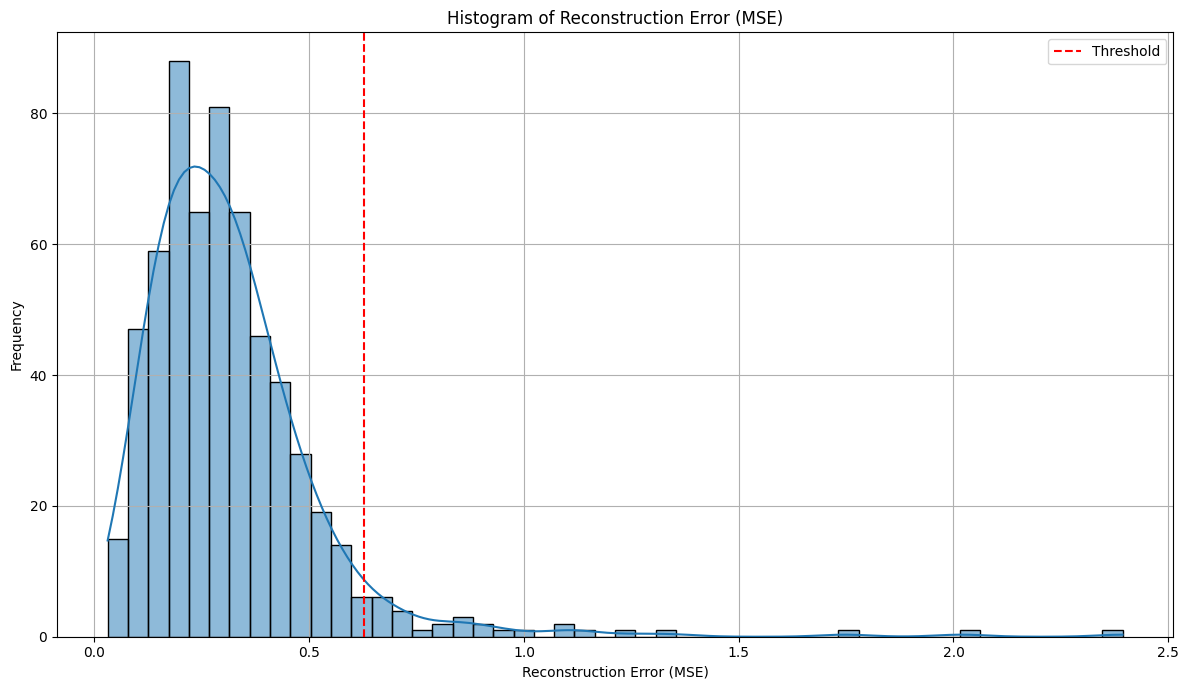

In [20]:
plt.figure(figsize = (12, 7))
sns.histplot(mse, bins = 50, kde = True)
plt.axvline(threshold, color = 'red', linestyle = '--', label = 'Threshold')
plt.title("Histogram of Reconstruction Error (MSE)")
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

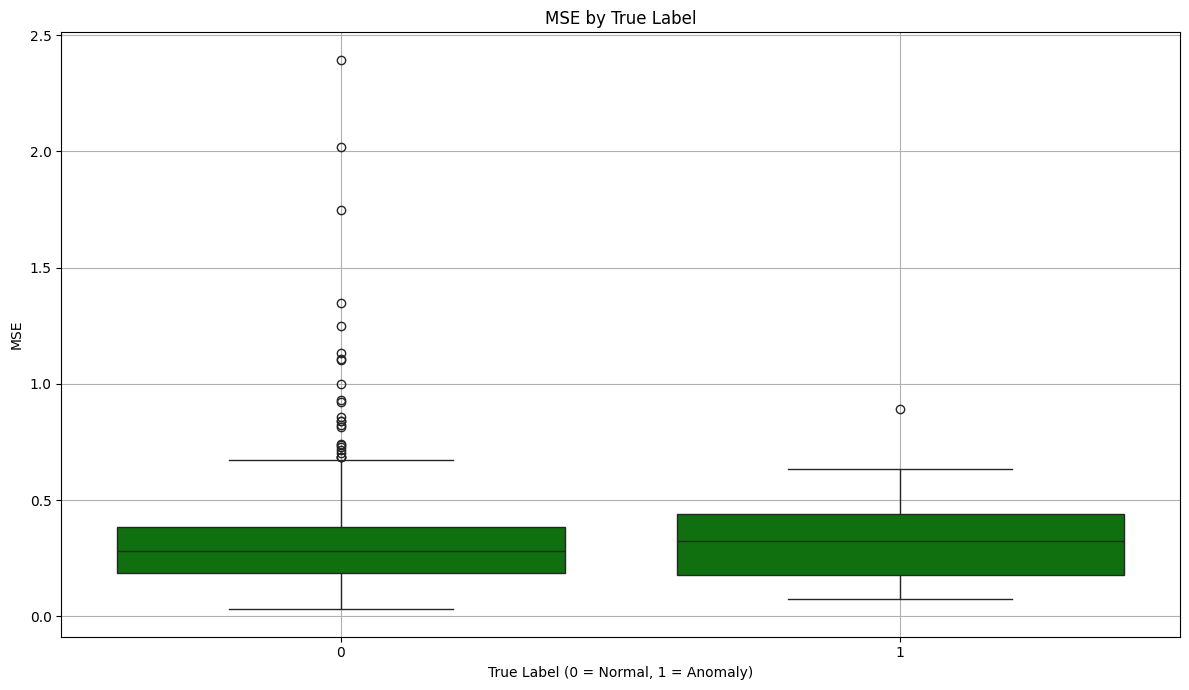

In [21]:
plt.figure(figsize=(12, 7))
sns.boxplot(x = y_test, y = mse, color = "green")
plt.title("MSE by True Label")
plt.xlabel("True Label (0 = Normal, 1 = Anomaly)")
plt.ylabel("MSE")
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
def detect_anomaly(input_data):
    input_scaled = sc.transform([input_data])
    recon = autoencoder.predict(input_scaled)
    error = np.mean(np.power(input_scaled - recon, 2))
    return "Anomaly" if error > threshold else "Normal"

# 3 samples
sample = x_test[14]
print("Real-time Detection Example 1:", detect_anomaly(sample))

sample = x_test[56]
print("Real-time Detection Example 2:", detect_anomaly(sample))

sample = x_test[270]
print("Real-time Detection Example 3:", detect_anomaly(sample))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Real-time Detection Example 1: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Real-time Detection Example 2: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Real-time Detection Example 3: Normal


In conclusion, this project successfully demonstrates the implementation of an anomaly detection system using both traditional machine learning and deep learning approaches. By simulating a dataset with injected anomalies, we were able to apply and compare three models: Isolation Forest, One-Class SVM, and a deep learning Autoencoder. Among them, the Autoencoder provided a robust way to learn normal data patterns and effectively flag deviations. Visualizations such as the reconstruction error distribution and boxplots enhanced interpretability. Finally, a simple deployment function was created to simulate real-time anomaly detection. This pipeline can be adapted for real-world anomaly detection tasks in domains such as finance, cybersecurity, and industrial systems.

In [13]:
# Finally

***I WOULD LIKE TO EXPRESS MY SINCERE GRATITUDE FOR YOUR TIME AND CONSIDERATION***

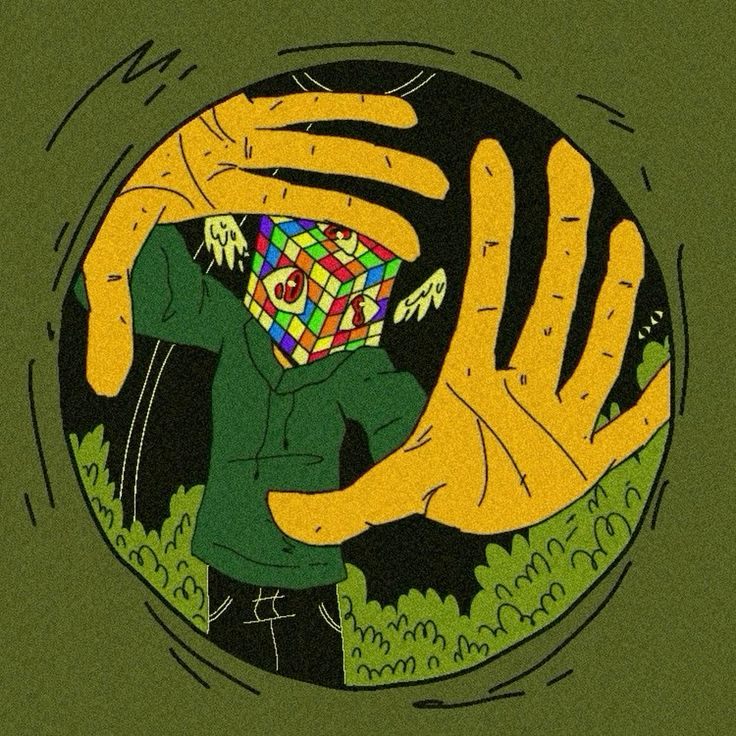